# Basics
In this notebook the basics of NMR are explained using the simulation at main.
At first, the whole setup must be done.

The use of a simulation ironically creates very contradictory additional difficulties.
On the one hand, it limits the accuracy of the measurement.
On the other hand, some settings are too precise and have to be altered
artificially in order to perform the measurements at all.
These difficulties will be explained further in the setup.

Another aspect is the accuracy we get.
The Larmor frequency can easily be in the magnitude of MHz or $10^6\,$Hz.
Within the simulation we work in ms.
Therefore, we need at least 1000 iterations per ms.
This is a large number and would cost a lot of time.
For some experiments it is not necessary to get the signal that detailed.
The `tfactor` is, therefore, chosen for every measurement depending on its needs.
Furthermore, GAMMA is reduced of a power of 6 resulting in an Larmor frequency in the 10 Hz regime and thus a tfactor >= 10.


In [1]:
from main import measure, GAMMA
from helper import view, view_phase
import matplotlib.pyplot as plt
import numpy as np
import os

## Loading the sample
At first, we need a sample to use. A sample is already created and saved in sample.npy.
It consists of three 2D arrays. Each of these arrays holds another material specific property.
This may seem a little awkward since we already know the results we try to measure but since
this is a simulation we have to add some "real" values to work with.

1. Density: The density of spins within this material
2. T1: The $T_1$ time of the material
3. T2: The $T_2$ time of the material

The used sample is a 2D container of oil. With $T_1=114\,$ms and $T_2=112\,$ms.

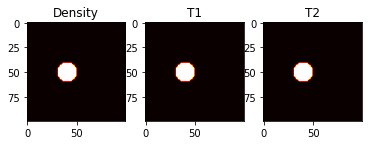

In [2]:
sample = np.load(f"{os.getcwd()}/sample.npy")
view(sample)

## Setup the NMR
Sources provided for the Lab course see:
https://www.physik.uni-wuerzburg.de/studium/master/f-praktikum/info-arbeits-material/ at NMR.
The explanations are based on what the tutor wanted to hear.

### Larmor precision
Classical:
Seeing the spin as a current of the rotating particle.

Consider the magnetic moment of a single electron in a coil:
$$\mu=I \cdot A$$
where $A$ is the surface of the coil and $I$ the current.
Since we only consider an electron (which does not change over time) we get:
$$\mu = \frac{Q}{T} \cdot A = \omega \frac{Q}{2\pi}\cdot r^2\pi=\frac{Q}{2m}\omega r^2 m =\frac{Q}{2m} L=\gamma L$$
Finally, follows:
$$\frac{d\vec{L}}{dt} = \vec{M}=\vec{\mu} \times \vec{B}=\gamma \vec{L}\times \vec{B}$$
The last line is basically the Bloch equation when relaxation is neglected.
Solving the DGL leads to:
$$\vec{\omega} = \gamma \vec{B}$$
Which is the Larmor frequency.

A little bit QM:

The orientation a spin can have in an external magnetic field is either $\uparrow$ or $\downarrow$.
At the same times holds:
$$[l^2, l_z] = 0$$
while
$$[l_x, l_y] = i\hbar I_z$$.
Using $|l| = \sqrt{l^2}$ we can thus measure the amplitude as well as the value in one direction.
The eigenvalues (for this fermions) are $\vec{s} = \pm \frac{\hbar}{2}$.
This leads to an energetic splitting:
![Zeeman effect - Image](figures/basics/zeeman.png)
This effect is also known as Zeeman effect.
The energetic difference is given by:
$$\Delta E = \hbar \gamma B$$
Using the energy for a photon $E = \omega \hbar$ yields
$$\omega = \gamma B$$

### Spin distribution
As both states are allowed both states are used.
For the relatively large temperature ($\approx 300\,$K) the distribution can be
described by the Boltzmann weights:
$$\frac{N_{\downarrow}}{N_{\uparrow}} \approx 1 - \frac{\hbar \omega}{k_B T}$$
Leading to a very small shift towards the energetic lower state.
But since the amount of spins is high even this slight difference causes a macroscopic
signal:
$$M = \frac{d\mu}{dV} = \frac{1}{V} \sum_i^N \mu_i=\frac{N \cdot \bar{\mu}}{V}=\rho \bar{\mu}$$

### Relaxation
Using an additional magnetic field $B_1$ the spins are placed into the xy-plane with
$\vec{B_0} = B_0 \hat{e}_z$. Here, they create a signal in our coil, which we measure.
Afterwards, the spins relax back into the equilibrium state.
This leads to 3 different effects

**$T_1$-Time**
This is the time $\frac{1}{e}$ of the magnetization in $z$ direction is restored.
Since the pulse flips this magnetization into the xy-plane (which we measure) the amplitude
we found is proportional to the magnetization in the $z$ direction. This relaxation is caused
by lattice-spin interactions.

**$T_2$-Time**
This is the time $\frac{1}{e}$ of the magnetization measured in the xy-plane decreases in.
This relaxation is caused by spin-spin interactions. It causes the amplitude measured after the
pulse to decrease. This decrease is called free induction decay or FID for short.

Both times are material specific properties and $T_2 \leq 2T_1$ hold


**$T_2'$-Time**
The last effect is caused by inhomogeneities of the magnetic field.
This leads to slightly different $\omega$ and thus to a dephasing over time.
It is the fastest of all three effects.

### Further simulation properties
We need a magnetic field as well as a time factor.
The time factor is related to the sample frequency.
It describes how many samples we take per ms.

In [3]:
tfactor = 40

b0_homo = np.zeros(sample.shape[:2])
b0_homo.fill(0.43)
b0 = b0_homo + np.random.normal(0, 1e-3, b0_homo.shape)

f_larmor = GAMMA * 0.43

This is where a limitation comes into account. Later we will use spin-echos
for the measurement. These echos depend on a dephasing of the spins due to
inhomogeneities of the applied magnetic field. Due to the computer we are able to
apply a perfectly homogeneous magnetic field. But since we want it to be
inhomogeneous at some point we add some random noise using the normal distribution.
The effect of this inhomogeneity can be shown easily.

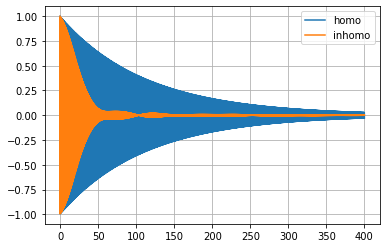

In [4]:
# setup measurement phase
t = 400 # ms
ts = np.linspace(0, t, t * tfactor, True)  # get times of the sample frequency
phases = np.zeros((t * tfactor, 4))
phases[0, 3] = np.pi / 2  # 90 pulse

sig_homo = np.real(measure(sample, b0_homo, tfactor, phases, f_larmor))
sig_inhomo = np.real(measure(sample, b0, tfactor, phases, f_larmor))

plt.plot(ts, sig_homo, label="homo")
plt.plot(ts, sig_inhomo, label="inhomo")
plt.grid()
plt.legend()
plt.show()

As can be decreases the inhomogeneous more rapidly.
The Larmor frequency depends on the magnetic field.
Since this field varies, the spins have different frequencies and dephase.
![Short gif how the spins dephase](figures/basics/dephasing.gif)
- decreasing amplitude

## Phases
- puls
- gradienten
### Spin-echo sequence
Now we will modify the above example to get some spin echos.

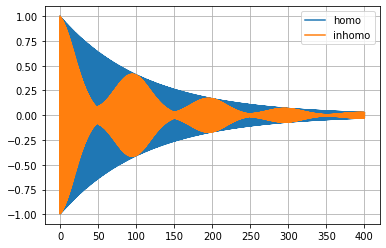

In [5]:
t = 400 # ms
ts = np.linspace(0, t, t * tfactor, True)  # get times of the sample frequency
phases = np.zeros((t * tfactor, 4))
phases[0, 3] = np.pi / 2  # 90 pulse
phases[tfactor * 50, 3] = np.pi
phases[tfactor * 150, 3] = np.pi
phases[tfactor * 250, 3] = np.pi
phases[tfactor * 350, 3] = np.pi

sig_homo = np.real(measure(sample, b0_homo, tfactor, phases, f_larmor))
sig_inhomo = np.real(measure(sample, b0, tfactor, phases, f_larmor))

plt.plot(ts, sig_homo, label="homo")
plt.plot(ts, sig_inhomo, label="inhomo")
plt.grid()
plt.legend()
plt.show()

Again looking at the spins this looks as follows:
![Short gif how the spins dephase and rephase](figures/basics/spin_echo.gif)